In [1]:
version = "v1.6.092820"

---
# Assignment 2 Part 1: Time Series Patterns (50 pts)

In this assignment, we're going to practise some techniques that are useful for discerning patterns in a time series. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

## Question 1: Load Data (5 pts)

At the time of writing this assignment, August 2020, COVID-19 is still the most topical public-health crisis globally with nearly 300,000 new cases reported worldwide every day. **The number of daily new cases worldwide** is a time series that arises naturally from this topical event, and in this assignment we'll apply some of the techniques we learned in class to this very time series to discern any patterns it may contain. 

You are provided with a csv file, `assets/time_series_covid19_confirmed_global.csv`, which is part of the [Johns Hopkins University CSSE COVID-19 dataset](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series). As the name suggests, it contains the number of *cumulative* confirmed cases globally as of certain dates. However, we are interested in the number of *new* cases worldwide every day. 

Create a function called `load_data` that reads in the csv file and produces a `pd.Series` that looks like: 

```
2020-01-23        99.0
2020-01-24       287.0
2020-01-25       493.0
2020-01-26       684.0
2020-01-27       809.0
                ...   
2020-08-17    209672.0
2020-08-18    255096.0
2020-08-19    274346.0
2020-08-20    267183.0
2020-08-21    270751.0
Length: 212, dtype: float64
```

where
* the index of the series is a `pd.DatetimeIndex`; 
* the values of the series are daily *new* cases worldwide; and
* the series doesn't contain any `NaN` values. 


**This function should return a `pd.Series` of length 212, whose index is a `pd.DatetimeIndex`.**

In [4]:
pd.set_option('display.max_columns', None)
def load_data():

    
    covid_df = pd.read_csv('assets/time_series_covid19_confirmed_global.csv')
    covid_df_transpose = covid_df.transpose()
    covid_df_transpose = covid_df_transpose.drop(labels = ['Province/State', 'Country/Region', 'Lat', 'Long'])
    covid_df_transpose['Total_Cases_Per_Date'] =  covid_df_transpose[list(covid_df_transpose.columns)].sum(axis=1)
    covid_df_transpose['New_Daily_Cases'] =   covid_df_transpose['Total_Cases_Per_Date'].diff()
    covid_df_transpose = covid_df_transpose.drop(labels = ['1/22/20'])
    covid_df_transpose = covid_df_transpose.reset_index()
    covid_df_transpose['index'] = pd.to_datetime(covid_df_transpose['index'])
    covid_df_transpose = covid_df_transpose.set_index(['index'])
    
    daily_new_cases  = pd.Series(covid_df_transpose['New_Daily_Cases'])
    
    return daily_new_cases


In [5]:
# Autograder tests

stu_ans = load_data()

assert isinstance(stu_ans, pd.Series), "Q1: Your function should return a pd.Series. "
assert len(stu_ans) == 212, "Q1: The length of the series returned is incorrect. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q1: The index of your series must be a pd.DatetimeIndex. "
assert (("2020-01-23" <= stu_ans.index) & (stu_ans.index <= "2020-08-21")).all(), "Q1: The index of your series contains an incorrect time range. "
assert not stu_ans.isna().any(), "Q1: Your series contains NaN values. "

# Some hidden tests


del stu_ans

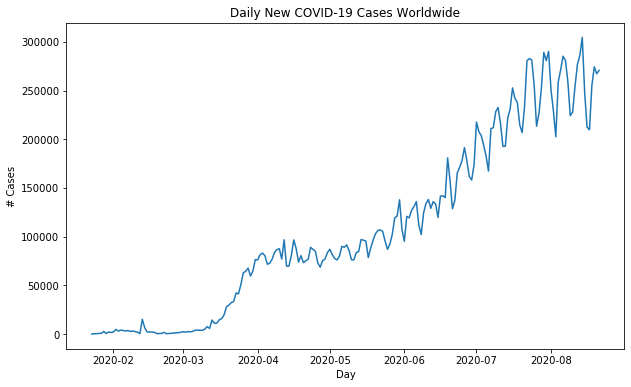

In [6]:
# Let's plot and see the time series

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(load_data())
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")

del fig, ax

## Question 2: Perform a Seasonal Decomposition (5 pts)

With the time series ready, let's first perform a seasonal decomposition using tools from the `statsmodels` library to get a sense of what the possible patterns are hidden in the data. Complete the function below that takes a time series and an argument `model`, which indicates whether an additive or multiplicative seasonal decomposition should be performed, and that returns a `DecomposeResult` as produced by the `seasonal_decompose` function from the `statsmodels` library. 

**This function should return a `statsmodels.tsa.seasonal.DecomposeResult`.**

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult

def sea_decomp(ser, model="additive"):
    """
    Takes in a series and a "model" parameter indicating which seasonal decomp to perform
    """
    series = load_data()
    
    
    
    result = seasonal_decompose(series, model='additive')
    

    
    return result

In [13]:
# Autograder tests

stu_ser = load_data()
stu_ans = sea_decomp(stu_ser, model="additive")

assert isinstance(stu_ans, DecomposeResult), "Q2: Your function should return a DecomposeResult. "

# Some hidden tests


del stu_ser, stu_ans

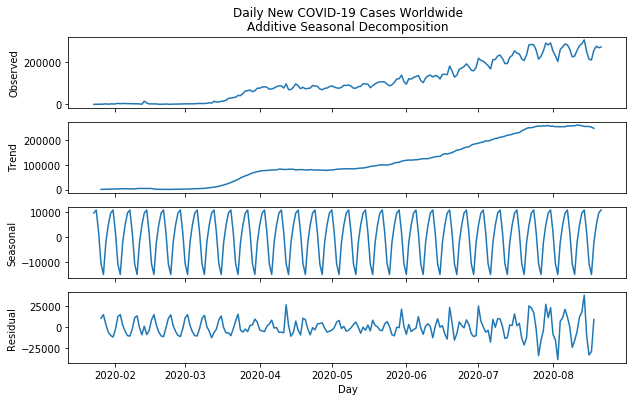

In [14]:
# Let's plot and see the seasonal decomposition

fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
res = sea_decomp(load_data(), model="additive")

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(res.observed)
axes[0].set_ylabel("Observed")

axes[1].plot(res.trend)
axes[1].set_ylabel("Trend")

axes[2].plot(res.seasonal)
axes[2].set_ylabel("Seasonal")

axes[3].plot(res.resid)
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Day")
fig.suptitle("Daily New COVID-19 Cases Worldwide", x=0.513, y=0.95)

del fig, axes, res

## Question 3: Fit a Trend Curve (15 pts)

The plot above suggests that there is a non-linear trend hidden in the time series. One approach to discover such a trend is to fit a regression model to the time series and ask the regression model to make predictions at each timestamp. When connected, these chronological predictions form a "trend curve". In the problem, we will explore how to fit a trend curve to our time series. 

Complete the function below that fits an `n`-th order polynomial to the input time series and that returns the predictions as a `np.ndarray` of the same length. An $n$-th order polynomial regression model assumes that each dependent variable $y_{i}$ is an $n$-th order polynomial function of the corresponding independent variable $x_{i}$:

\begin{equation*}
y_{i} = c_{0} + c_{1}x_{i} + c_{2}x_{i}^{2} + \cdots + c_{n}x_{i}^{n}
\end{equation*}

Now, the most interesting and important question to think about is, "**what are $x_{i}$'s and $y_{i}$'s in the problem?**". The $y_{i}$'s are the daily new cases worldwide at timestamps $x_{i}$'s, but **how should we represent the timestamps $x_{i}$'s in such a regression model?** There are many choices you may explore. In the function below, you are already given the code for training a polynomial regression model, but you have to figure out what `train_X` ($x_{i}$'s) and `train_y` ($y_{i}$'s) are. Since it's possible that everyone has a different design, this question is graded on the $R^{2}$ score of your predictions. **For a $10$-th order polynomial regression model, at least one choice of $x_{i}$'s leads to an $R^{2}$ score $\geq 0.95$.** 

**This function should return a `np.ndarray` of shape `(len(ser), )`, which represents the predictions of your polynomial regression model on the input time series. The predictions form the "trend curve" we are looking for.**

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def fit_trend(ser, n):
    """
    Takes a series and fits an n-th order polynomial to the series. 
    Returns the predictions. 
    """
    dataframe = ser
    dataframe = dataframe.to_frame()

    
    
    X = np.arange(1, len(ser)+1, 1)
    Y = np.array(dataframe['New_Daily_Cases']).reshape(-1, 1) 
    
    
   
    train_X, train_y = X, Y # xi's and yi's

    # Create train_X and train_y
    # YOUR CODE HERE

    
    # Fit a polynomial regression model - code given to you
    train_X = PolynomialFeatures(n).fit_transform(train_X.reshape(-1, 1))
    lin_reg = LinearRegression().fit(train_X, train_y.reshape(-1))
    
    # Make predictions to create the trend curve
    # YOUR CODE HERE
    
    trend_curve = lin_reg.predict(train_X)

    
    return trend_curve
    
    

In [10]:
# Autograder tests

stu_ser = load_data()
stu_ans = fit_trend(stu_ser, 10)

assert isinstance(stu_ans, np.ndarray), "Q3: Your function should return a np.ndarray. "
assert stu_ans.shape == (len(stu_ser), ), "Q3: The shape of your np.ndarray is not correct. "

# Some hidden tests


del stu_ser, stu_ans

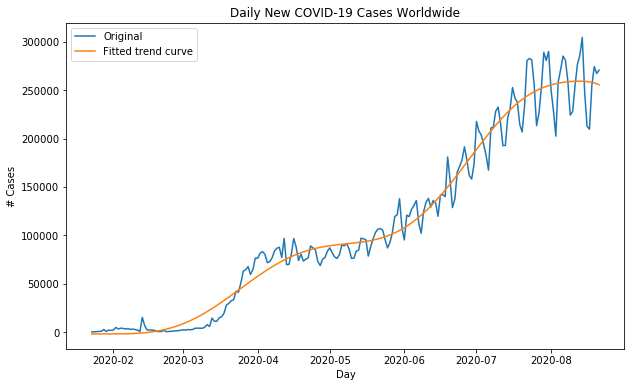

In [11]:
# Let's plot and see your regression line

fig, ax = plt.subplots(figsize=(10, 6))
ser = load_data()
preds = fit_trend(ser, 10)
ax.plot(ser.index, ser.values, label="Original")
ax.plot(ser.index, preds, label="Fitted trend curve")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax, ser, preds

It's worth mentioning that the `seaborn` library provides a function [`regplot`](https://seaborn.pydata.org/generated/seaborn.regplot.html) that can plot both the data and the regression line in a few lines of code, thus saving you the trouble of fitting a regression model. 

## Question 4: Calculate Weighted Moving Average (WMA) (15 pts)

The regression method seems to give a fairly accurate description of the trend hidden in the time series. In this problem and the next, we will explore an alternative method for discovering trends that is based on moving averages.

Recall from the lectures that a Weighted Moving Average (WMA) method applies the following transformation to each data point $x_{j}$:

\begin{equation*}
x_{j}^{\prime} = \frac{w_{k}x_{j} + w_{k - 1}x_{j - 1} + \cdots + w_{1}x_{j - k + 1}}{w_{k} + w_{k - 1} + \cdots + w_{1}}
\end{equation*}

for a window of size $k$. Complete the function below that calculates the WMA for an input time series. 

**This function should return a `np.ndarray` of shape `(len(ser), )` that represents the WMA values for the input time series.**

In [12]:
from pandas import DataFrame
def calc_wma(ser, wd_size, weights=1):
    """
    Takes in a series and calculates the WMA with a window size of wd_size
    """
    wma = None
    if isinstance(weights, int):
        weights = np.full(wd_size, weights)
        

    assert len(weights) == wd_size, "Q4: The size of the weights must be the same as the window size. "
    


    sum_weights = weights.sum()
    dataframe = ser
    dataframe.to_frame()
    dataframe = dataframe.reset_index()
    dataframe = dataframe.rename(columns={"index": "Date"})
    
    weights_reversed = weights[::-1]
    
    
    wma = ser.rolling(wd_size).apply(lambda x: np.dot(x, weights)/sum_weights, raw=True).to_numpy()
    
    daily_cases_list = dataframe['New_Daily_Cases'].to_list()
    daily_cases_list_slice = daily_cases_list[0:6]
 
    
    
    new_six = []
    x1 = daily_cases_list_slice[0]
    y1 = weights_reversed[0]
    first = (x1*y1)/y1
    new_six.append(first)
    x2 = daily_cases_list[0:2]
    y2 = weights_reversed[0:2]
    y2 = list(y2)
    y2.reverse()
    second = np.dot(x2, y2)/sum(y2)
    new_six.append(second)
    x3 = daily_cases_list[0:3]
    y3 = weights_reversed[0:3]
    y3 = list(y3)
    y3.reverse()
    third = np.dot(x3, y3)/sum(y3)
    new_six.append(third)
    x4 = daily_cases_list[0:4]
    y4 = weights_reversed[0:4]
    y4 = list(y4)
    y4.reverse()
    fourth = np.dot(x4, y4)/sum(y4)
    new_six.append(fourth)
    x5 = daily_cases_list[0:5]
    y5 = weights_reversed[0:5]
    y5 = list(y5)
    y5.reverse()
    fifth = np.dot(x5, y5)/sum(y5)
    new_six.append(fifth)
    x6 = daily_cases_list[0:6]
    y6 = weights_reversed[0:6]
    y6 = list(y6)
    y6.reverse()
    six = np.dot(x6, y6)/sum(y6)
    new_six.append(six)


#     count = 1
#     while count < 6:
#         tmp_list1 = daily_cases_list_slice[0:count + 1]
#         tmp_list2 = weights[0:count + 1]
#         tmp_list2 = list(tmp_list2)
#         tmp_list2.reverse()
#         i = np.dot(tmp_list1, tmp_list2)/sum(tmp_list2)
#         new_six.append(i)
#         count = count + 1

    
    wma = list(wma)
    wma = new_six + wma
    wma = [x for x in wma if str(x) != 'nan']
    wma =  pd.Series(wma) 
    wma = wma.to_numpy()
    return wma
  


In [13]:
# Autograder tests

wd_size = 7
weights = np.arange(1, wd_size + 1) # linear weighting
stu_ser = load_data()
stu_ans = calc_wma(stu_ser, wd_size, weights)

assert isinstance(stu_ans, np.ndarray), "Q4: Your function should return a np.ndarray. "
assert stu_ans.shape == (len(stu_ser), ), "Q4: The np.ndarray returned is of an incorrect shape. "

# Some hidden tests


del wd_size, weights, stu_ser, stu_ans

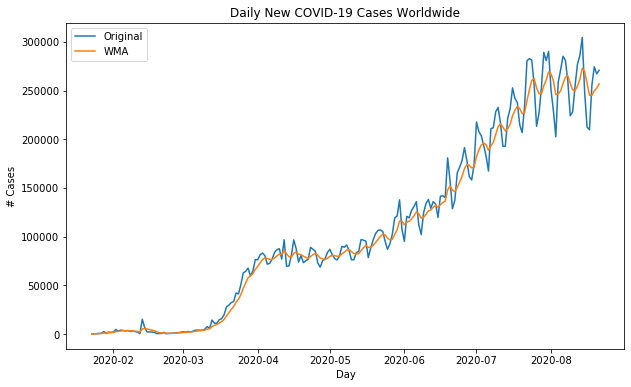

In [14]:
# Let's plot and see your WMA

fig, ax = plt.subplots(figsize=(10, 6))
wd_size = 7
weights = np.arange(1, wd_size + 1)
ser = load_data()
wma = calc_wma(ser, wd_size, weights=weights)

ax.plot(ser.index, ser.values, label="Original")
ax.plot(ser.index, wma, label="WMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax, wd_size, weights, ser, wma

## Question 5: Calculate "Time" Exponential Moving Average (EMA) (10 pts)

WMA usually works well if each data point is sampled at regular time intervals (which is the case for our time series). "Time" Exponential Moving Average (EMA), on the other hand, works well on both regular and irregular time series. Let's now explore how to apply EMA to our time series.

Recall from the lectures that a "time" EMA method applies the following transformation to each data point $x_{j}$:

\begin{equation*}
x_{j}^{\prime} = \frac{\sum_{i = 1}^{j}\exp\left[-\lambda\left(t_{j} - t_{i}\right)\right]x_{i}}{\sum_{i = 1}^{j}\exp\left[-\lambda\left(t_{j} - t_{i}\right)\right]}
\end{equation*}

where $0 \leq \lambda \leq 1$ is the "decay rate". Also note that, when $\lambda = 0$, this is equivalent to a cumulative moving average (CMA). Complete the function below that calculates the "time" EMA for an input time series, **assuming the time intervals are days**.

**This function should return a `np.ndarray` of shape `(len(ser), )`, which represents the "time" EMA for the input time series.**

In [48]:
import math
def calc_time_ema(ser, lmbd=0.0):
    """
    Takes in a series and calculates EMA with the lambda provided
    """
    
    halflife_ser = np.log(2)/lmbd
    halflife_ser = str(halflife_ser) + ' days'

    time_ema = None
    ema_list = []
    
    dataframe = ser.to_frame()
    
    dataframe = dataframe.reset_index()
    times_list = dataframe['index'].to_list()
    just_daily_cases = dataframe['New_Daily_Cases'].to_list()
    just_daily_cases_df =  pd.DataFrame(just_daily_cases, columns = ['New_Daily_Cases'])
    dataframe['Time_Delta'] =  range(len(dataframe))
    dataframe['Time_Delta'] = dataframe['Time_Delta'].astype(int)
    time_delta_list = dataframe['Time_Delta'].to_list()
    
    if lmbd == 0.0:
        dataframe['CMA'] = dataframe.New_Daily_Cases.expanding().mean()
        time_ema = dataframe['CMA'].to_list()
        time_ema =  pd.Series(time_ema) 
        time_ema = time_ema.to_numpy()
        

    if lmbd != 0.0:
        just_daily_cases_df = pd.DataFrame(just_daily_cases, columns = ['Daily_Cases'])
        time_ema = just_daily_cases_df.ewm(halflife=halflife_ser, times=pd.DatetimeIndex(times_list)).mean()
        time_ema = time_ema['Daily_Cases'].to_list()
        time_ema =  pd.Series(time_ema) 
        time_ema = time_ema.to_numpy()
        

        


    
    return time_ema

In [49]:
stu_ser = load_data()

# Sanity checks for a trivial case - CMA
stu_ans = calc_time_ema(stu_ser, lmbd=1.0)
stu_ans

array([9.90000000e+01, 2.36439013e+02, 4.07113889e+02, 5.85404804e+02,
       7.27702720e+02, 1.94647952e+03, 1.08697292e+03, 1.70730840e+03,
       1.69826265e+03, 1.95917426e+03, 3.72270992e+03, 3.32907976e+03,
       3.76013654e+03, 3.75056841e+03, 3.37662574e+03, 3.51340037e+03,
       3.02072535e+03, 3.02658805e+03, 2.76262206e+03, 2.30710204e+03,
       1.11296180e+03, 9.98795859e+03, 7.80021551e+03, 4.22354116e+03,
       2.93430526e+03, 2.36583592e+03, 2.05999329e+03, 1.07388946e+03,
       7.49049367e+02, 6.73163694e+02, 1.36080739e+03, 7.40818874e+02,
       6.29048029e+02, 7.70612674e+02, 9.01074346e+02, 1.19369917e+03,
       1.30956739e+03, 1.67963138e+03, 2.12487727e+03, 2.02950464e+03,
       2.37621983e+03, 2.32740759e+03, 2.62045388e+03, 3.45646247e+03,
       3.82406430e+03, 3.90619933e+03, 3.90228060e+03, 4.61134250e+03,
       6.54035794e+03, 6.04075644e+03, 1.13292310e+04, 1.11893863e+04,
       1.11638573e+04, 1.33782658e+04, 1.49388034e+04, 1.78827131e+04,
      

In [50]:
# Autograder tests

stu_ser = load_data()

# Sanity checks for a trivial case - CMA
stu_ans = calc_time_ema(stu_ser, lmbd=0.0)

assert isinstance(stu_ans, np.ndarray), "Q5: Your function should return a np.ndarray. "
assert stu_ans.shape == (len(stu_ser), ), "Q5: The np.ndarray returned is of an incorrect shape. "
assert np.isclose(stu_ans, np.cumsum(stu_ser) / np.arange(1, len(stu_ser) + 1)).all(), "Q5: When lmbd = 0 your function should calculate CMA. "


# Redefine the variable for hidden tests - lmbd=0.5
stu_ans = calc_time_ema(stu_ser, lmbd=0.5)


# Some hidden tests


del stu_ser, stu_ans

In [ ]:
# Let's plot and see your time EMA

fig, ax = plt.subplots(figsize=(10, 6))
ser = load_data()
ema = calc_time_ema(ser, lmbd=0.5)

ax.plot(ser.index, ser.to_numpy(), label="Original")
ax.plot(ser.index, ema, label="Time EMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax, ser, ema

The [`SimpleExpSmoothing`](https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html#) class from the `statsmodels` library is a handy tool for EMA. See an example below. 

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing

fig, ax = plt.subplots(figsize=(10, 6))

ser = load_data()
ema = SimpleExpSmoothing(ser, initialization_method=None).fit(smoothing_level=0.5, optimized=False)

ax.plot(ser, label="Original")
ax.plot(ema.fittedvalues, label="EMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del ser, ema, fig, ax